# Image Classification with HOG Feature and SVM

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.utils import shuffle

## 1. Dataset Preparation

**Visualization configuration**

In [5]:
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

**Read CSV files / Load image data**

In [6]:
train_df = pd.read_csv('emnist-letters-train.csv', header=None)
test_df = pd.read_csv('emnist-letters-test.csv', header=None)

In [7]:
print(train_df.head())
print(train_df.columns)


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            775, 776, 777, 778, 779, 780, 781, 782, 783, 784],
           dtype='int64', length=785)


**Training and testing data are combined into one dataframe.**


In [8]:
data = pd.concat([train_df, test_df], ignore_index=True)

**Shuffle Data**
**Randomize the order of data to ensure random class distribution during processing.**

In [9]:
data = shuffle(data, random_state=42)

**Balance Data**
**Take exactly 100 examples from each class (1 to 26) to keep the dataset balanced.**

In [10]:
print(data.columns)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            775, 776, 777, 778, 779, 780, 781, 782, 783, 784],
           dtype='int64', length=785)


In [11]:
samples_per_class = 100
balanced_data = pd.concat([
    data[data[0] == i].iloc[:samples_per_class] for i in range(1, 27)
], ignore_index=True)


**Separating image labels and features**
**The image is resized to 28x28 pixels for visualization and feature extraction purposes.**

In [12]:
y = balanced_data.iloc[:, 0].values
X = balanced_data.iloc[:, 1:].values.reshape(-1, 28, 28)

**Visualize Some Samples**
**Displaying the first 26 images of the dataset with letter labels for data verification.**

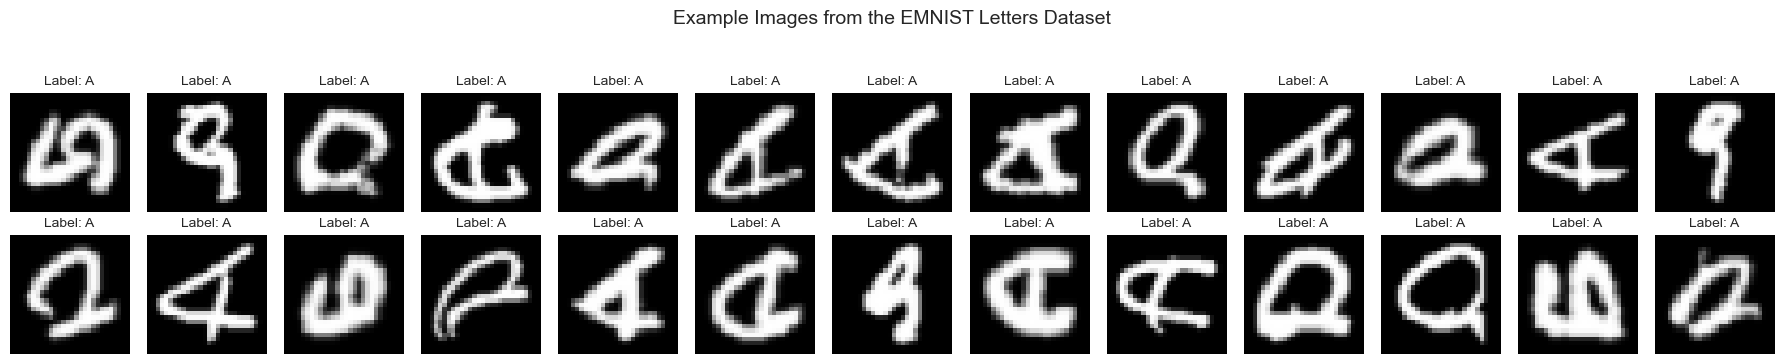

In [13]:
fig, axes = plt.subplots(2, 13, figsize=(18, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i], cmap='gray')
    ax.set_title(f"Label: {chr(y[i] + 64)}", fontsize=10)  # Konversi 1–26 ke A–Z
    ax.axis('off')
plt.suptitle("Example Images from the EMNIST Letters Dataset", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. Feature Extraction

**Test extract HOG feature from image**

In [14]:
# HOG parameters are adjusted to obtain a good representation.
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

In [15]:
X_hog = extract_hog_features(X)

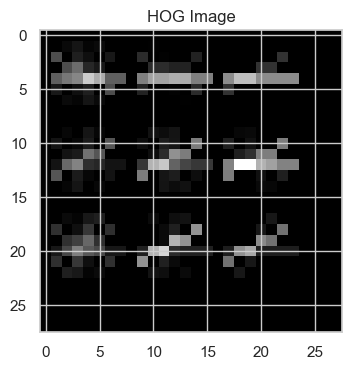

In [16]:
image_data = train_df.iloc[0, 1:].values.reshape(28, 28)  # Asumsi kolom 0 adalah label
feature, hog_image = hog(image_data, orientations=9, pixels_per_cell=(8, 8), 
                         cells_per_block=(2, 2), visualize=True, block_norm='L2')

# Tampilkan hasil HOG
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Image")
plt.show()

In [17]:
feature.shape

(144,)

<BarContainer object of 144 artists>

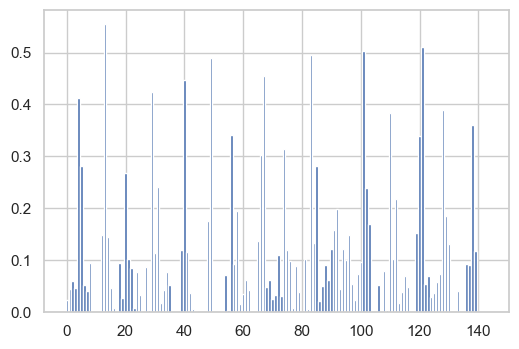

In [18]:
plt.bar(list(range(feature.shape[0])), feature)

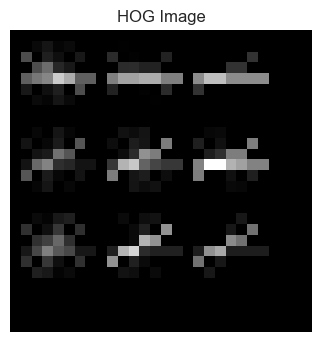

In [19]:
image_array = train_df.iloc[0, 1:].values.reshape(28, 28)

# Hitung HOG
feature, hog_image = hog(image_array,
                         orientations=9,
                         pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2),
                         visualize=True,
                         block_norm='L2')

# Tampilkan hasil HOG
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Image")
plt.axis('off')
plt.show()


<BarContainer object of 144 artists>

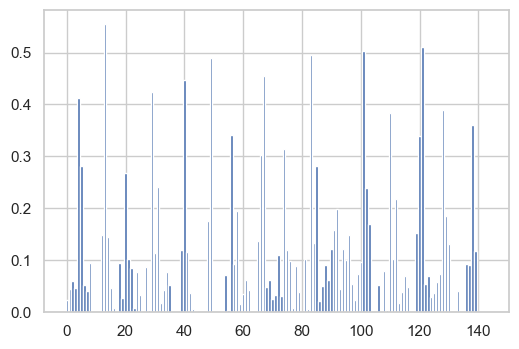

In [20]:
plt.bar(list(range(feature.shape[0])), feature)

## 3. Classification

**Train-Test Split**
**Divide the data into training data (80%) and test data (20%) while maintaining the class proportions.**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hog, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
X_train.shape

(2080, 144)

**Determining the parameter grid for the SVM model: kernel, C, and gamma**

**This grid will be tested to find the best combination.**

In [23]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

**Performing the best parameter search with GridSearchCV and validation**

In [24]:
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

**Displaying the best parameters of grid search results**

In [83]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


**Evaluate Best Model Use the best model to predict test data and evaluate its performance.**

In [25]:
y_pred = grid.best_estimator_.predict(X_test)

In [27]:
import pandas as pd

hasil_df = pd.DataFrame({
    'Prediksi': y_pred,
    'Label_Asli': y_test 
})
print(hasil_df.head(10))



   Prediksi  Label_Asli
0         5           5
1        25          25
2        19          19
3        23          23
4        20          20
5        16          16
6         2          12
7        22          22
8        10          10
9        26          26


In [28]:
from sklearn.metrics import accuracy_score

akurasi = accuracy_score(y_test, y_pred)
print(f"Akurasi model: {akurasi:.2f}")

Akurasi model: 0.77


## 4. Evaluation Metrics

### 4.1 Displays evaluation metrics: precision, recall, f1-score, and accuracy.

In [29]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.60      0.59        20
           2       0.65      0.55      0.59        20
           3       0.65      0.75      0.70        20
           4       0.89      0.85      0.87        20
           5       0.65      0.65      0.65        20
           6       0.84      0.80      0.82        20
           7       0.60      0.45      0.51        20
           8       0.76      0.80      0.78        20
           9       0.44      0.40      0.42        20
          10       0.94      0.80      0.86        20
          11       0.95      0.90      0.92        20
          12       0.52      0.65      0.58        20
          13       0.73      0.95      0.83        20
          14       0.69      0.55      0.61        20
          15       0.94      0.85      0.89        20
          16       0.84      0.80      0.82        20
          17       0.65      0.85      0.74        20
   

### 4.2 Precission

$$\text { Precision }=\frac{T P}{T P+F P}$$

In [106]:
from sklearn.metrics import precision_score

In [107]:
precision = precision_score(y_test, y_pred, average=None)

In [108]:
precision

array([0.53722084, 0.7833002 , 0.64917127, 0.78513514, 0.85294118,
       0.76586103, 0.71454219, 0.66338798, 0.42429577, 0.86482558,
       0.92238806, 0.44169184, 0.8637037 , 0.66335541, 0.83892617,
       0.85302198, 0.70945946, 0.78133705, 0.7987013 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

### 4.3 Recall

$$\text { Recall }=\frac{T P}{T P+F N}$$

In [109]:
from sklearn.metrics import recall_score

In [110]:
recall = recall_score(y_test, y_pred, average=None)

C:\Users\yogaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
recall

array([0.54125, 0.4925 , 0.88125, 0.72625, 0.6525 , 0.63375, 0.4975 ,
       0.75875, 0.30125, 0.74375, 0.7725 , 0.91375, 0.72875, 0.75125,
       0.78125, 0.77625, 0.525  , 0.70125, 0.9225 , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ])

### 4.4 Accuracy

$$\text { Accuracy }=\frac{T P+T N}{T P+T N+F P+F N}$$

In [112]:
from sklearn.metrics import accuracy_score

In [113]:
accuracy = accuracy_score(y_test, y_pred)

In [114]:
accuracy

0.6832432432432433

### 4.5 F1-Score

$$\text { F1-Score }=\left(\frac{2}{\text { precision }^{-1}+\text { recall }^{-1}}\right)=2 \cdot\left(\frac{\text { precision } \cdot \text { recall }}{\text { precision }+\text { recall }}\right)$$

In [115]:
from sklearn.metrics import f1_score

In [116]:
f1 = f1_score(y_test, y_pred, average='macro')

In [117]:
f1

0.5106790434716617


# Displays a confusion matrix to see the prediction error between classes.

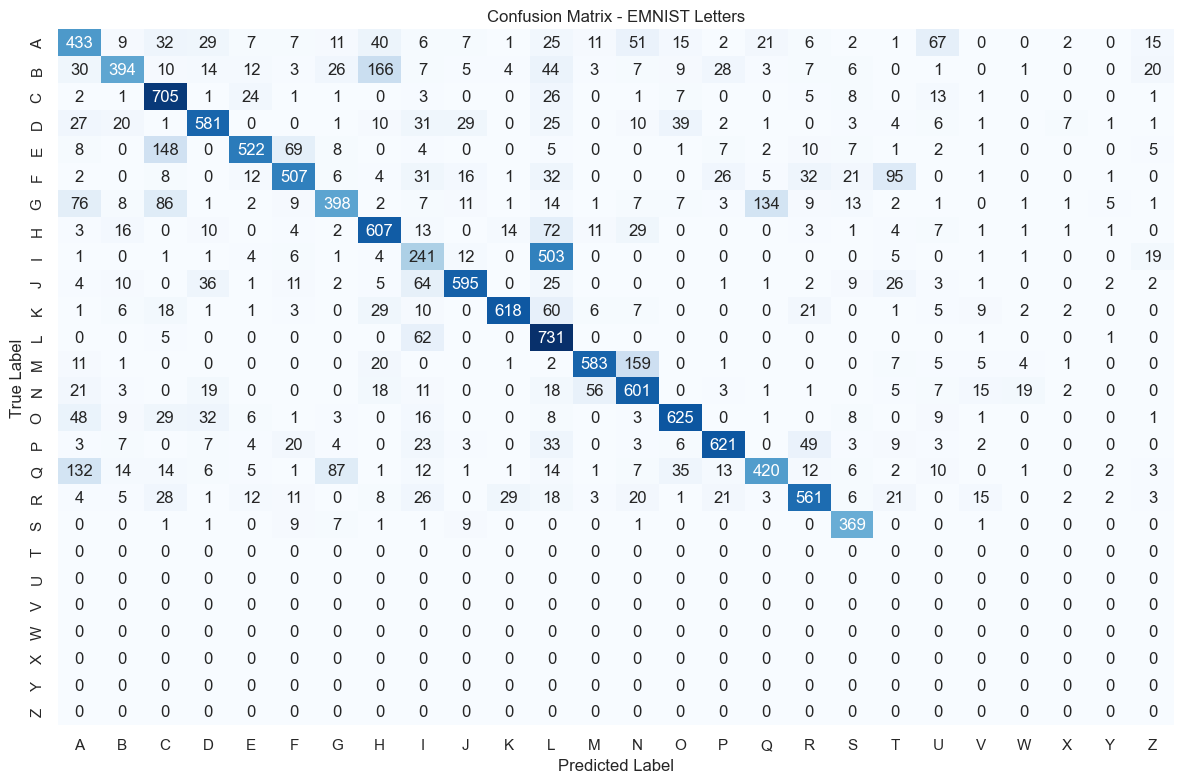

In [118]:
plt.figure(figsize=(12, 8))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[chr(i + 64) for i in range(1, 27)],
            yticklabels=[chr(i + 64) for i in range(1, 27)])
plt.title("Confusion Matrix - EMNIST Letters")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
